## "This is a model on MINST DATASET from TORCHVISION to recognise digits."

In [1]:
!pip install torch-summary

In [2]:
import torch
import torchvision
import  matplotlib.pyplot as plt
from torchsummary import summary
import sklearn
import sklearn.metrics
from tqdm.auto import tqdm
import numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cpu


# Data Loading And PreProcessing  

In [3]:
transform =torchvision.transforms.ToTensor()

train_data = torchvision.datasets.MNIST('./train',download=True,train=True,transform=transform)
train_data , val_data = torch.utils.data.random_split(train_data,[0.8,0.2])

test_data = torchvision.datasets.MNIST('./test',download=True,train=False,transform=transform)

train_loader= torch.utils.data.DataLoader(train_data,batch_size=64,shuffle=True)
test_loader= torch.utils.data.DataLoader(test_data,batch_size=64,shuffle=True)
val_loader= torch.utils.data.DataLoader(val_data,batch_size=64,shuffle=True)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]


Extracting ./train/MNIST/raw/train-images-idx3-ubyte.gz to ./train/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 487kB/s]


Extracting ./train/MNIST/raw/train-labels-idx1-ubyte.gz to ./train/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]


Extracting ./train/MNIST/raw/t10k-images-idx3-ubyte.gz to ./train/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.44MB/s]


Extracting ./train/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./train/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]


Extracting ./test/MNIST/raw/train-images-idx3-ubyte.gz to ./test/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]


Extracting ./test/MNIST/raw/train-labels-idx1-ubyte.gz to ./test/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]


Extracting ./test/MNIST/raw/t10k-images-idx3-ubyte.gz to ./test/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.47MB/s]

Extracting ./test/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./test/MNIST/raw



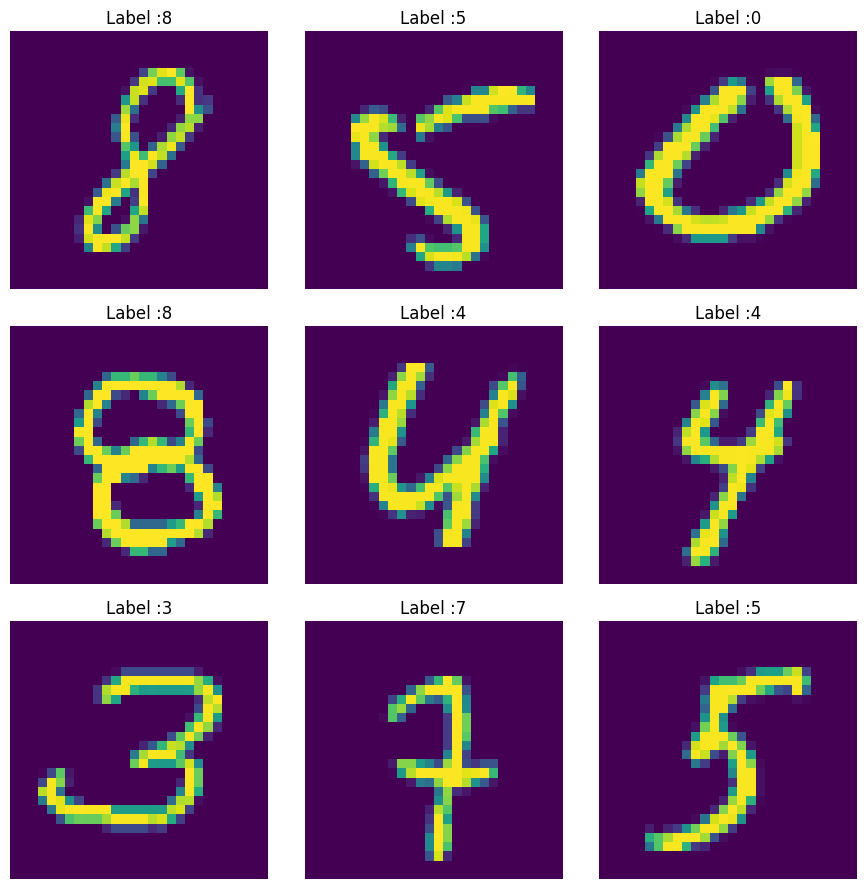

In [4]:
plt.figure(figsize=(9,9))
for i, data in enumerate(train_loader):
    if i<9:
        x,y=data
        img,label=x[0,:,:,:],y[0].item() # items for primitive conversion form tensor
        npimg=img.numpy()

        plt.subplot(3,3,i+1)
        plt.imshow(npimg.squeeze())
        plt.axis("off")
        plt.title(f"Label :{label}") 

plt.tight_layout()
plt.show()

In [5]:
print(f'Data shape: {x.shape}')
print(f'Label shape: {y.shape}')

Data shape: torch.Size([64, 1, 28, 28])
Label shape: torch.Size([64])


## Creating  MLP

In [6]:
input_Size=28*28
hidden_layer=1024
output_layer=10

model = torch.nn.Sequential(torch.nn.Linear(input_Size,hidden_layer)
                           ,torch.nn.ReLU()
                           ,torch.nn.Linear(hidden_layer,output_layer))
summary(model,data[0].flatten(start_dim=1))


Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 1024]                803,840
├─ReLU: 1-2                              [-1, 1024]                --
├─Linear: 1-3                            [-1, 10]                  10,250
Total params: 814,090
Trainable params: 814,090
Non-trainable params: 0
Total mult-adds (M): 0.81
Input size (MB): 0.19
Forward/backward pass size (MB): 0.01
Params size (MB): 3.11
Estimated Total Size (MB): 3.30


Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 1024]                803,840
├─ReLU: 1-2                              [-1, 1024]                --
├─Linear: 1-3                            [-1, 10]                  10,250
Total params: 814,090
Trainable params: 814,090
Non-trainable params: 0
Total mult-adds (M): 0.81
Input size (MB): 0.19
Forward/backward pass size (MB): 0.01
Params size (MB): 3.11
Estimated Total Size (MB): 3.30

In [7]:
optimiser=torch.optim.Adam(model.parameters(),lr=.001)
criterion=torch.nn.CrossEntropyLoss()

In [8]:

def train_epochs(model,optimiser,criterion,data_loader):
    model.train()
    pred_data=[]
    true_data=[]
    train_loss=0.0
    for i,(imgs,labels) in enumerate(tqdm(data_loader)):
        imgs=imgs.to(device)
        labels=labels.to(device)

        model_out=model(imgs.flatten(start_dim=1))

        loss=criterion(model_out,labels)
        train_loss+=loss.item()
        
        pred=torch.argmax(model_out,dim=1).squeeze()
        pred_data.extend(pred.cpu().tolist())
        true_data.extend(labels.cpu().tolist())

        #backprop
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    # average loss:
    train_loss/=len(data_loader)

    # loss:
    train_accuracy=sklearn.metrics.accuracy_score(true_data,pred_data)*100
    return train_loss,train_accuracy
    

In [9]:
def eval(model,data_loader):
    model.eval()
    pred_data=[]
    true_data=[]
    total_loss=0.0
    for i,(imgs,labels) in enumerate(tqdm(data_loader)):
        imgs=imgs.to(device)
        labels=labels.to(device)

        model_out=model(imgs.flatten(start_dim=1))

        loss=criterion(model_out,labels)
        total_loss+=loss.item()
        
        pred=torch.argmax(model_out,dim=1)
        pred_data.extend(pred.cpu().tolist())
        true_data.extend(labels.cpu().tolist())
        optimiser.zero_grad
        loss.backward()
        optimiser.step()

    # average loss:
    val_loss=total_loss/len(data_loader)

    # loss:
    val_accuracy=sklearn.metrics.accuracy_score(true_data,pred_data)*100
    return val_loss,val_accuracy
        

## Testing the model

In [10]:
num_epochs=15
train_loss_list=[]
val_loss_list=[]
train_acc_list=[]
val_acc_list=[]

for epoch in range(num_epochs):
    train_loss, train_accuracy = train_epochs(model, optimiser, criterion, train_loader)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_accuracy)

    val_loss, val_accuracy = eval(model, val_loader)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_accuracy)
    print(f'Epoch {epoch} train_loss: {train_loss:.4f} \t train_acc: {train_accuracy:.4f}% \t val_loss: {val_loss:.4f} \t val_acc: {val_accuracy:.4f}%')

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 0 train_loss: 0.2512 	 train_acc: 92.6917% 	 val_loss: 5.2539 	 val_acc: 64.4500%


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 1 train_loss: 1.2594 	 train_acc: 86.7854% 	 val_loss: 0.9618 	 val_acc: 84.9583%


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 2 train_loss: 0.5868 	 train_acc: 89.9271% 	 val_loss: 0.3744 	 val_acc: 91.0250%


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 3 train_loss: 0.3925 	 train_acc: 90.0708% 	 val_loss: 0.2819 	 val_acc: 92.6833%


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 4 train_loss: 0.3722 	 train_acc: 92.0125% 	 val_loss: 0.2780 	 val_acc: 92.6000%


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 5 train_loss: 0.3788 	 train_acc: 91.3833% 	 val_loss: 0.2870 	 val_acc: 92.9167%


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 6 train_loss: 0.4033 	 train_acc: 92.1188% 	 val_loss: 0.2916 	 val_acc: 93.0083%


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 7 train_loss: 0.4327 	 train_acc: 90.9104% 	 val_loss: 0.2636 	 val_acc: 93.5833%


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 8 train_loss: 0.3719 	 train_acc: 92.4521% 	 val_loss: 0.2563 	 val_acc: 94.7833%


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 9 train_loss: 0.4705 	 train_acc: 93.1917% 	 val_loss: 0.4111 	 val_acc: 91.9500%


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 10 train_loss: 0.4465 	 train_acc: 90.3854% 	 val_loss: 0.2985 	 val_acc: 93.1583%


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 11 train_loss: 0.4533 	 train_acc: 92.2083% 	 val_loss: 0.1723 	 val_acc: 95.6000%


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 12 train_loss: 0.3948 	 train_acc: 92.9167% 	 val_loss: 0.1721 	 val_acc: 95.7833%


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 13 train_loss: 0.3770 	 train_acc: 92.3125% 	 val_loss: 0.2150 	 val_acc: 95.2333%


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 14 train_loss: 0.4558 	 train_acc: 92.6771% 	 val_loss: 0.2528 	 val_acc: 94.6000%


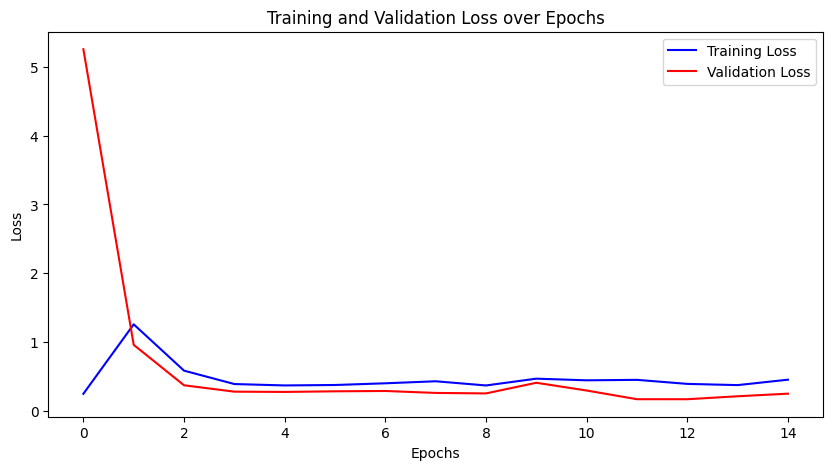

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label='Training Loss', color='blue')
plt.plot(val_loss_list, label='Validation Loss', color='red')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(False)
plt.show()

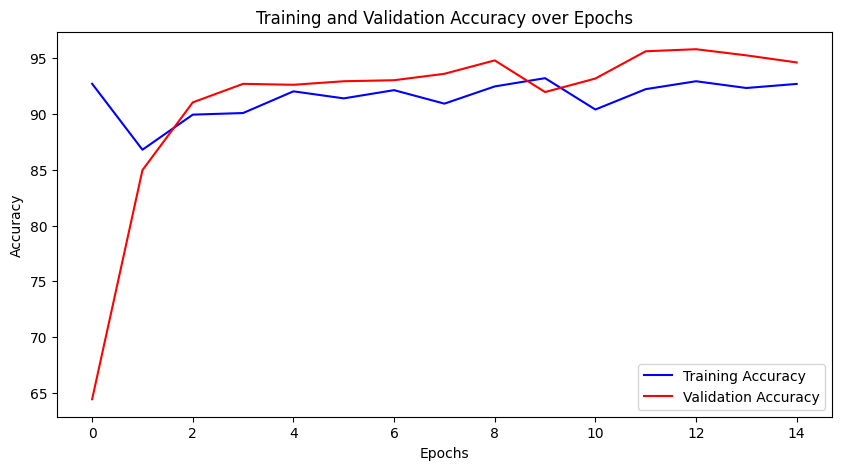

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(train_acc_list, label='Training Accuracy', color='blue')
plt.plot(val_acc_list, label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(False)
plt.show()

In [13]:
test_loss, test_acc = eval(model, test_loader)
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_acc}%')

  0%|          | 0/157 [00:00<?, ?it/s]

Test loss: 0.9299
Test accuracy: 83.13000000000001%
